# A First Model

Suppose the data is organized in a long format where each individual appears in more than one row: 


| Id |Faa |week | sex | group |
|:--:|:--:|:---:|:---:|:-----:|
|1  |5	| 1 | G = 0 | T 
|2  |2	| 1 | B = 1 | A
|1  |8	| 3	| G = 0 | T
|1  |1	| 2 | G = 0 | T


Then, the model for the $i^{th}$ observation is:

$$ \Large
Faa_i = \alpha_0 + \alpha_{sex} \ sex_i + \alpha_{group} \ group_i + \alpha_{week} \ week_i + \alpha_{j[i]}
$$

where $j[i]$ is the id of the subject corresponding to observation $i$. So for example, if we consider the third observation, then $i = 3$ and $j[i] = 1$. 

The last coefficient represents an indivual random effect that, for example, we can set to: 

$$ \Large 
\alpha_{j} \sim \mathcal{N}\left(0, \ \sigma_j^2\right)
$$

In [1]:
library(haven)
library(tidyverse)
library(broom)
library(lme4) 

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand



In [2]:
aaSelect <- function(df, AA){
    aaDf <- df %>% select(id = ID, group = GROUP, age = MATERNALAGE, sex = SEXO, starts_with(AA)) %>%
                         mutate(id = factor(id), 
                                sex =  factor(sex, labels = c('girl', 'boy')),
                                group = factor(group, labels = c('teen', 'adult'))) 
    
    return(aaDf)
}

aaLong <-  function(df, AA){
    aaL <- df %>% gather(week, level, starts_with(AA))
    
    aaL[aaL == paste(AA, 'Calostrum', sep = '')] = 1
    aaL[aaL == paste(AA, 'Transition', sep = '')] = 2
    aaL[aaL == paste(AA, 'Mature2m', sep = '')] = 8
    aaL[aaL == paste(AA, 'Mature4m', sep = '')] = 16

    aaL <- aaL %>% mutate(week = as.numeric(week))
    
    return(aaL)
}

In [3]:
AA_Sex_1 <- read_sav("C:/Users/Personal/AA leche/datos/AMINOACIDOS POR SEXO_1.sav")
head(AA_Sex_1)

ID,GROUP,MATERNALAGE,SEXO,INFANTDOB,MATBMI1COLL,MATBMI215d,MATBMI32mos,MATBMI44mos,BABYWeigth1g,...,ALAGLOB,ASNGLOB,SYSGLOB,GLYGLOB,GLUGLOB,GLNGLOB,PROLINEGLOB,SERINEGLOB,TYRAMINEGLOB,new
1,0,17,1,2009-08-20,25,24,24,22,3492.7,...,21.25,0.5,1.00,10.00,87.25,23.25,2.75,8.0,1.00,0
2,0,16,2,2009-08-24,32,31,30,29,3392.9,...,18.25,0.0,0.75,13.75,100.50,40.50,2.50,9.5,0.75,0
3,0,17,2,2009-08-21,23,23,NA,NA,2993.8,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
4,0,16,2,2009-08-21,26,NA,NA,NA,3692.3,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
5,0,16,NA,2009-08-29,25,NA,NA,NA,3592.5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
6,0,16,2,2009-08-27,29,28,30,31,3093.5,...,15.50,0.5,1.50,10.25,74.75,30.00,5.25,8.0,2.00,0


In [4]:
AA <- 'GLU'

AAdf <- aaSelect(AA_Sex_1, AA) %>% select(-contains('GLOB')) 
AAdf <- AAdf %>% filter(!is.na(AAdf$sex))

head(AAdf)

Warning message:
"`as_dictionary()` is soft-deprecated as of rlang 0.3.0.
Please use `as_data_pronoun()` instead
This warning is displayed once per session."Warning message:
"`new_overscope()` is soft-deprecated as of rlang 0.2.0.
Please use `new_data_mask()` instead
This warning is displayed once per session."Warning message:
"The `parent` argument of `new_data_mask()` is deprecated.
The parent of the data mask is determined from either:

  * The `env` argument of `eval_tidy()`
  * Quosure environments when applicable
This warning is displayed once per session."Warning message:
"`overscope_clean()` is soft-deprecated as of rlang 0.2.0.
This warning is displayed once per session."

id,group,age,sex,GLUCalostrum,GLUTransition,GLUMature2m,GLUMature4m
1,teen,17,girl,89,89,99,72
2,teen,16,boy,4,103,104,191
3,teen,17,boy,54,122,NA,NA
4,teen,16,boy,33,NA,NA,NA
6,teen,16,boy,30,67,92,110
7,teen,16,boy,34,97,115,130


In [5]:
AAdfLong <- aaLong(AAdf, AA)
head(AAdfLong)

Warning message:
"attributes are not identical across measure variables; they will be dropped"

id,group,age,sex,week,level
1,teen,17,girl,1,89
2,teen,16,boy,1,4
3,teen,17,boy,1,54
4,teen,16,boy,1,33
6,teen,16,boy,1,30
7,teen,16,boy,1,34


In [6]:
mod1 <- lmer(level ~ sex + group + week + (1 | id), data=AAdfLong)
summary(mod1)

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ sex + group + week + (1 | id)
   Data: AAdfLong

REML criterion at convergence: 1824.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.08751 -0.52853 -0.02919  0.61700  2.87567 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  215.4   14.68   
 Residual             1211.1   34.80   
Number of obs: 183, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  56.3690     6.6255   8.508
sexboy       13.1931     6.7666   1.950
groupadult   -5.2495     6.8277  -0.769
week          4.1004     0.4529   9.054

Correlation of Fixed Effects:
           (Intr) sexboy grpdlt
sexboy     -0.686              
groupadult -0.532  0.236       
week       -0.354  0.001 -0.061

In [7]:
fixef(mod1)

(Intercept)      sexboy  groupadult        week 
  56.369046   13.193084   -5.249536    4.100407

In [8]:
ranef(mod1)

$id
    (Intercept)
1    1.33163072
2    1.35529191
3    3.22419218
4   -6.14059988
6   -9.34943688
7   -1.34687264
8   23.07653771
9   -3.41637349
10   9.65302198
11   2.25076272
12  -6.56448272
13   7.27926804
14  -7.08665114
15  -2.59402551
16  19.16153460
17  -5.65893487
18   9.76687092
19  -4.96303386
20 -17.76771874
21  -5.05434575
22  -2.81103580
23  -3.73724897
24  -8.55681903
25   3.97731783
26  13.77749350
28  -0.33123977
29  -5.82371837
30   8.21463269
31 -11.94767202
32   3.72200706
33   8.23485960
34  -2.33609920
35   1.71695566
36 -12.52794206
37  -0.01945155
38   4.40499766
39  -3.11367254
41 -14.13038247
42   0.29214374
45  -3.08264260
46 -12.78906642
47  -7.46203981
48  -9.14477785
49  -5.77173089
50  -2.02554672
51  -5.36612228
52   1.04331077
53   1.74715542
54   1.33143780
55  11.85196896
56  -0.95500913
57  18.27193093
58   5.48861403
59   0.80698390
61  19.31122499
62   6.65549868
63  -1.37072675
64  -2.17850081
65  -4.41260762
66   1.57181480
67   0.31706933


In [9]:
mod2 <- lmer(level ~ sex + week + week:sex +  (1 | id), data=AAdfLong)
summary(mod2)

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ sex + week + week:sex + (1 | id)
   Data: AAdfLong

REML criterion at convergence: 1828.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.91969 -0.56760 -0.02618  0.62104  2.93674 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  208.8   14.45   
 Residual             1215.7   34.87   
Number of obs: 183, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  55.8559     6.2726   8.905
sexboy       10.5215     8.2838   1.270
week          3.6964     0.6749   5.477
sexboy:week   0.6964     0.9100   0.765

Correlation of Fixed Effects:
            (Intr) sexboy week  
sexboy      -0.757              
week        -0.611  0.463       
sexboy:week  0.453 -0.613 -0.742

In [10]:
mod3 <- lmer(level ~ group + week + week:group + (1 | id), data=AAdfLong)
summary(mod3)

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ group + week + week:group + (1 | id)
   Data: AAdfLong

REML criterion at convergence: 1831.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.11876 -0.54679 -0.03097  0.63446  2.89086 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  233.3   15.27   
 Residual             1222.8   34.97   
Number of obs: 183, groups:  id, 61

Fixed effects:
                Estimate Std. Error t value
(Intercept)      66.9257     5.3453  12.520
groupadult      -12.5097     8.5084  -1.470
week              3.7699     0.6188   6.092
groupadult:week   0.7188     0.9140   0.786

Correlation of Fixed Effects:
            (Intr) grpdlt week  
groupadult  -0.628              
week        -0.598  0.376       
groupdlt:wk  0.405 -0.608 -0.677

In [11]:
lm3 <- lm(level ~ group + week + week:group, data=AAdfLong)
summary(lm3)


Call:
lm(formula = level ~ group + week + week:group, data = AAdfLong)

Residuals:
    Min      1Q  Median      3Q     Max 
-124.92  -24.98   -2.16   21.78  122.12 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      67.4422     5.1073  13.205  < 2e-16 ***
groupadult      -12.3016     8.1252  -1.514    0.132    
week              3.7174     0.6589   5.642 6.47e-08 ***
groupadult:week   0.8391     0.9813   0.855    0.394    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 38.09 on 179 degrees of freedom
  (61 observations deleted due to missingness)
Multiple R-squared:  0.2856,	Adjusted R-squared:  0.2736 
F-statistic: 23.86 on 3 and 179 DF,  p-value: 4.906e-13


# Missing data: 

There is a trend in missing data in this experiment. It increases over time and it is bigger for teenage mothers. There are two possible interpretations for this phenomenon: 

One in which we assume that time and teen variables are the cause of dessertion. In this case, the probability that the level variable is missing only depends on available information and these missing observations can be discarded.  

And another in which this probability depends on an unobserved variable, like the discomfort caused by the data collection. Since, we haven't observed a discomfot predictor we are forced to model the mechanism by which the data will be replaced. **By doing so, we imagine what would be the result of the analysis if the data was completely observed**. 



In [12]:
nPart <- AAdf %>% group_by(group) %>% summarize(num = n()) 
Missind_data <- AAdf %>% group_by(group) %>% summarise_all(funs(sum(is.na(.)))) %>% inner_join(nPart)
Missind_data

Joining, by = "group"


group,id,age,sex,GLUCalostrum,GLUTransition,GLUMature2m,GLUMature4m,num
teen,0,0,0,0,8,14,18,37
adult,0,0,0,0,6,9,6,24


In [15]:
nPart <- AAdf %>% group_by(sex) %>% summarize(num = n()) 
nPart

Missind_data <- AAdf %>% group_by(sex) %>% summarise_all(funs(sum(is.na(.)))) %>% inner_join(nPart)
Missind_data

sex,num
girl,26
boy,35


Joining, by = "sex"


sex,id,group,age,GLUCalostrum,GLUTransition,GLUMature2m,GLUMature4m,num
girl,0,0,0,0,6,11,9,26
boy,0,0,0,0,8,12,15,35


In [12]:
pMissind_data <- 
    Missind_data %>% mutate(GLUTransition = GLUTransition/num, 
                        GLUMature2m = GLUMature2m/num, 
                        GLUMature4m = GLUMature4m/num) %>% select(-num)

pMissind_data

group,id,age,sex,GLUCalostrum,GLUTransition,GLUMature2m,GLUMature4m
teen,0,0,0,0,0.2162162,0.3783784,0.4864865
adult,0,0,0,0,0.2500000,0.3750000,0.2500000


In [13]:
pMD_Long <- aaLong(pMissind_data, AA) %>% select(group, week, pNA = level) 
pMD_Long

group,week,pNA
teen,1,0.0000000
adult,1,0.0000000
teen,2,0.2162162
adult,2,0.2500000
teen,8,0.3783784
adult,8,0.3750000
teen,16,0.4864865
adult,16,0.2500000


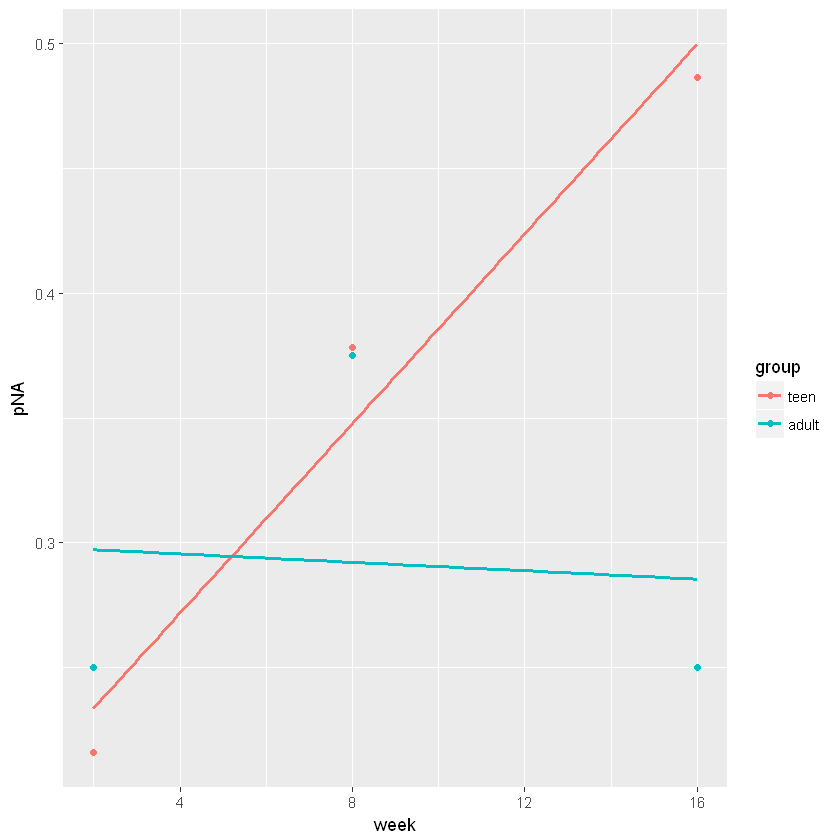

In [15]:
ggplot(pMD_Long %>% filter(week != 1), aes(x = week, y = pNA, color = group)) + 
    geom_point() + geom_smooth(method = lm, formula = y ~ x, se = F)

In [18]:
modMD <- lm(pNA ~ week + group, pMD_Long %>% filter(week != 1))
summary(modMD)


Call:
lm(formula = pNA ~ week + group, data = pMD_Long %>% filter(week != 
    1))

Residuals:
       1        2        3        4        5        6 
-0.08365  0.01882  0.02407  0.08938  0.05959 -0.10821 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.281722   0.086142   3.270   0.0468 *
week         0.009074   0.007257   1.250   0.2998  
groupadult  -0.068694   0.083240  -0.825   0.4697  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1019 on 3 degrees of freedom
Multiple R-squared:  0.4279,	Adjusted R-squared:  0.04657 
F-statistic: 1.122 on 2 and 3 DF,  p-value: 0.4327


### Regression Imputation: 

I am assuming that given the group variable, the mechanism is ignorable.

Idea is to impute the values using a regression model that takes into account the week and group variables.

$$
\Large
Faa = \alpha_0 + \alpha_1 \ group + \alpha_2 \ sex + \alpha_3 \ week 
$$

where the time effect for adult is $\alpha_2 + \alpha_3$.  


In [92]:
lm3 <- lm(level ~ sex + group + week, data=AAdfLong)
summary(lm3)


Call:
lm(formula = level ~ sex + group + week, data = AAdfLong)

Residuals:
     Min       1Q   Median       3Q      Max 
-120.363  -23.154   -0.483   22.416  119.298 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  56.8060     5.9495   9.548  < 2e-16 ***
sexboy       12.7018     5.8121   2.185   0.0302 *  
groupadult   -4.2192     5.8583  -0.720   0.4723    
week          4.0973     0.4829   8.485 7.94e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 37.67 on 179 degrees of freedom
  (61 observations deleted due to missingness)
Multiple R-squared:  0.3013,	Adjusted R-squared:  0.2896 
F-statistic: 25.74 on 3 and 179 DF,  p-value: 6.869e-14


In [94]:
lm3 <- lm(level ~ sex + week + sex:week , data=AAdfLong)
summary(lm3)


Call:
lm(formula = level ~ sex + week + sex:week, data = AAdfLong)

Residuals:
    Min      1Q  Median      3Q     Max 
-114.52  -23.62   -1.02   21.11  121.45 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  56.5199     6.0126   9.400  < 2e-16 ***
sexboy       10.3658     7.9406   1.305    0.193    
week          3.7499     0.7214   5.198 5.46e-07 ***
sexboy:week   0.5840     0.9695   0.602    0.548    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 37.68 on 179 degrees of freedom
  (61 observations deleted due to missingness)
Multiple R-squared:  0.3007,	Adjusted R-squared:  0.289 
F-statistic: 25.66 on 3 and 179 DF,  p-value: 7.417e-14


In [95]:
pred_lm3 <- predict(lm3, AAdfLong) 
length(pred_lm3)
dim(AAdfLong)

[1] 244

[1] 244   6

In [96]:
AAdfLong %>% filter(is.na(level) ) %>% head()

id,group,age,sex,week,level
4,teen,16,boy,2,NA
12,teen,16,girl,2,NA
21,teen,18,girl,2,NA
24,teen,18,boy,2,NA
25,teen,17,boy,2,NA
33,teen,16,girl,2,NA


In [97]:
imputed_level <- ifelse(is.na(AAdfLong$level), pred_lm3, AAdfLong$level) 

In [98]:
AAdfLong_imputed <- AAdfLong %>% mutate(imputed_level = imputed_level)
head(AAdfLong_imputed)

id,group,age,sex,week,level,imputed_level
1,teen,17,girl,1,89,89
2,teen,16,boy,1,4,4
3,teen,17,boy,1,54,54
4,teen,16,boy,1,33,33
6,teen,16,boy,1,30,30
7,teen,16,boy,1,34,34


In [99]:
AAdfLong %>% filter(id == 4)
AAdfLong_imputed %>% filter(id == 4)

id,group,age,sex,week,level
4,teen,16,boy,1,33
4,teen,16,boy,2,NA
4,teen,16,boy,8,NA
4,teen,16,boy,16,NA


id,group,age,sex,week,level,imputed_level
4,teen,16,boy,1,33,33.00000
4,teen,16,boy,2,NA,75.55352
4,teen,16,boy,8,NA,101.55687
4,teen,16,boy,16,NA,136.22800


In [100]:
m1 <- lmer(level ~ sex + group + week + (1 | id), data=AAdfLong_imputed)
m1_imputed <- lmer(imputed_level ~ sex + group + week + (1 | id), data=AAdfLong_imputed)
summary(m1_imputed)
summary(m1)

Linear mixed model fit by REML ['lmerMod']
Formula: imputed_level ~ sex + group + week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 2371.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5817 -0.4289  0.0125  0.3561  3.4176 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 127.6    11.30   
 Residual             936.7    30.61   
Number of obs: 244, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)   55.775      5.026  11.098
sexboy        13.745      5.014   2.741
groupadult    -3.033      5.076  -0.598
week           4.085      0.328  12.455

Correlation of Fixed Effects:
           (Intr) sexboy grpdlt
sexboy     -0.647              
groupadult -0.505  0.188       
week       -0.441  0.000  0.000

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ sex + group + week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 1824.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.08751 -0.52853 -0.02919  0.61700  2.87567 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  215.4   14.68   
 Residual             1211.1   34.80   
Number of obs: 183, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  56.3690     6.6255   8.508
sexboy       13.1931     6.7666   1.950
groupadult   -5.2495     6.8277  -0.769
week          4.1004     0.4529   9.054

Correlation of Fixed Effects:
           (Intr) sexboy grpdlt
sexboy     -0.686              
groupadult -0.532  0.236       
week       -0.354  0.001 -0.061

In [102]:
m2 <- lmer(level ~ sex + week +  (1 | id), data=AAdfLong_imputed)
m2_imputed <- lmer(imputed_level ~ sex + week +  (1 | id), data=AAdfLong_imputed)
summary(m2_imputed)
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: imputed_level ~ sex + week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 2376.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5556 -0.4423  0.0168  0.3690  3.4477 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 123.7    11.12   
 Residual             936.7    30.61   
Number of obs: 244, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)   54.258      4.320  12.559
sexboy        14.308      4.898   2.921
week           4.085      0.328  12.455

Correlation of Fixed Effects:
       (Intr) sexboy
sexboy -0.650       
week   -0.512  0.000

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ sex + week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 1830.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0354 -0.5579 -0.0244  0.6202  2.9186 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  204.5   14.30   
 Residual             1215.5   34.86   
Number of obs: 183, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  53.6939     5.5755   9.630
sexboy       14.3976     6.5221   2.208
week          4.0794     0.4526   9.013

Correlation of Fixed Effects:
       (Intr) sexboy
sexboy -0.680       
week   -0.461  0.016

In [104]:
m3 <- lmer(level ~ sex + week +  sex:week + (1 | id), data=AAdfLong_imputed)
m3_imputed <- lmer(imputed_level ~ sex + week + sex:week + (1 | id), data=AAdfLong_imputed)
summary(m3_imputed)
summary(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: imputed_level ~ sex + week + sex:week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 2374.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4529 -0.4579  0.0443  0.3625  3.4853 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 123.4    11.11   
 Residual             937.9    30.62   
Number of obs: 244, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  56.5199     5.0276  11.242
sexboy       10.3658     6.6373   1.562
week          3.7499     0.5027   7.460
sexboy:week   0.5840     0.6636   0.880

Correlation of Fixed Effects:
            (Intr) sexboy week  
sexboy      -0.757              
week        -0.675  0.511       
sexboy:week  0.511 -0.675 -0.757

Linear mixed model fit by REML ['lmerMod']
Formula: level ~ sex + week + sex:week + (1 | id)
   Data: AAdfLong_imputed

REML criterion at convergence: 1828.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.91969 -0.56760 -0.02618  0.62104  2.93674 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept)  208.8   14.45   
 Residual             1215.7   34.87   
Number of obs: 183, groups:  id, 61

Fixed effects:
            Estimate Std. Error t value
(Intercept)  55.8559     6.2726   8.905
sexboy       10.5215     8.2838   1.270
week          3.6964     0.6749   5.477
sexboy:week   0.6964     0.9100   0.765

Correlation of Fixed Effects:
            (Intr) sexboy week  
sexboy      -0.757              
week        -0.611  0.463       
sexboy:week  0.453 -0.613 -0.742